## RNA Bind-n-Seq
RNA Bind-n-Seq dataset (RBNS) is designed to dissect the sequence and RNA structural
preferences of RBPs. An
RBP is incubated with a pool of randomized RNAs at several
different protein concentrations, typically ranging from low nanomolar to low micromolar. 

The RNA pool typically
consists of random RNAs of length 40 nt flanked by short
primers used to add the adapters needed for deep sequencing.

RBPbound RNA is reverse-transcribed into cDNA, and barcoded
sequencing adapters are added by PCR to produce libraries
for deep sequencing. Libraries corresponding to the input RNA
pool and to five or more RBP concentrations (including zero
RBP concentration as an additional control) are sequenced in
a single Illumina HiSeq 2000 lane, typically yielding at least 15–
20 million reads per library.

Most RBPs bind single-stranded RNA sequence motifs 3–8 nt
in length. 

In [143]:
from keras.utils import to_categorical

In [144]:
def parse_RBNS_file(file_name):
    
    rnas = set()
    with open(file_name) as f:
        for line in f:
            rna = line.strip().split()[0]
            rnas.add(rna)
    
    return rnas

Exploring the dataset

In [145]:
files = ['RBP1_input.seq', 'RBP1_5nM.seq', 'RBP1_20nM.seq', 'RBP1_80nM.seq', 'RBP1_320nM.seq', 'RBP1_1300nM.seq']
rnas_sets = []

for i, file_name in enumerate(files):
    rnas_set = parse_RBNS_file(file_name)
    rnas_sets.append(rnas_set)

In [153]:
for i, rna_set in enumerate(rnas_sets):
    print(files[i], '\t', len(rna_set))

RBP1_input.seq 	 19572050
RBP1_5nM.seq 	 9280450
RBP1_20nM.seq 	 9807899
RBP1_80nM.seq 	 16205127
RBP1_320nM.seq 	 14691937
RBP1_1300nM.seq 	 17443521


In [147]:
len(rnas_sets[0].intersection(*rnas_sets[1:3]))

1

Intersection of sequences between different consentrations

In [148]:
for i in range(len(rnas_sets)-1):
    set1 = rnas_sets[i]
    for j in range(i+1, len(rnas_sets)):
        set2 = rnas_sets[j]
        print('i={}, j={}, intersection={}'.format(i, j, len(set1.intersection(set2))))

i=0, j=1, intersection=260
i=0, j=2, intersection=263
i=0, j=3, intersection=454
i=0, j=4, intersection=352
i=0, j=5, intersection=434
i=1, j=2, intersection=7000
i=1, j=3, intersection=1452
i=1, j=4, intersection=1705
i=1, j=5, intersection=1623
i=2, j=3, intersection=2498
i=2, j=4, intersection=3659
i=2, j=5, intersection=2705
i=3, j=4, intersection=496
i=3, j=5, intersection=615
i=4, j=5, intersection=781


In [4]:
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D

import matplotlib.pyplot as plt
%matplotlib inline

import numpy as np
import pandas as pd
import os

In [16]:
kernel_size = 12
max_size = 45

reverse_compliment_base = {'A': 'U', 'C': 'G', 'T': 'A', 'G': 'C', 'N': 'N'}

def reverse_compliment(string):
    string = [reverse_compliment_base[base] for base in string[::-1]]
    
    return ''.join(string)

def pad(string, max_size):
    string += 'N' * (max_size-len(string))
    return string

def pad_conv(string, kernel_size):
    pad = 'N'*(kernel_size-1)
    string = pad + string + pad
    return string

def read_file_rncmpt(file_path):
    sequences = []
    with open(file_path) as f:
        for line in f:
            sequences.append(line.strip())
    return sequences

def read_file_rbns(path):
    sequences = []
    with open(path, 'r') as f:
        for line in f:
            sequences.append(line.strip().split())
    return sequences


def one_hot(string):

    dict = {'A': np.array([1, 0, 0, 0]), 'G': np.array([0, 1, 0, 0]),
            'C': np.array([0, 0, 1, 0]), 'U': np.array([0, 0, 0, 1]),
            'N': np.array([0.25]*4)}
    
    vec_list = [dict[c].reshape(1, -1) for c in string]
    
    return np.concatenate(vec_list, axis=0).reshape(len(string), 4, 1)


def get_files_list(rbp_ind):
    lst = []
    for file in os.listdir(PATH):
        if file.startswith('RBP' + str(rbp_ind)):
            consentration = file.split('_')[1].split('nM')[0]
            consentration_val = 0
            if consentration != 'input.seq':
                consentration_val = int(consentration)
                
            lst.append((file, consentration_val))
    lst.sort(key=lambda x: x[1])
    
    return [file for file,cons in lst]


def get_x(str_dict):
    x = [entry['x'] for entry in str_dict]
    return x


def get_str_dict(seqs_lists):
    str_dict = {}
    for lst_ind, seqs in enumerate(seqs_lists):
        for seq, count in seqs:
            if seq in str_dict:
                str_dict[seq]['y'][lst_ind] = 1
            else:
                str_dict[seq] = {'x': one_hot(pad_conv(pad(seq, max_size), kernel_size)), 
                                 'y': [1 if i == lst_ind else 0 for i in range(len(seqs_lists))]}
    return list(str_dict.values())


def get_y(str_dict):
    y = [entry['y'] for entry in str_dict]
    return y

In [17]:
PATH = 'RBNS/'

l = get_files_list(1)

seqs_lists = []
for file in l:
    seqs = read_file_rbns(PATH + file)
    rc_seqs = [(reverse_compliment(seq), count) for (seq, count) in seqs]
    seqs_lists.append(rc_seqs)

str_dict = get_str_dict(seqs_lists)
x_train = get_x(str_dict)
y_train = get_y(str_dict)

In [19]:
x_train[0].shape

(67, 4, 1)

In [20]:
x_train[0]

array([[[0.25],
        [0.25],
        [0.25],
        [0.25]],

       [[0.25],
        [0.25],
        [0.25],
        [0.25]],

       [[0.25],
        [0.25],
        [0.25],
        [0.25]],

       [[0.25],
        [0.25],
        [0.25],
        [0.25]],

       [[0.25],
        [0.25],
        [0.25],
        [0.25]],

       [[0.25],
        [0.25],
        [0.25],
        [0.25]],

       [[0.25],
        [0.25],
        [0.25],
        [0.25]],

       [[0.25],
        [0.25],
        [0.25],
        [0.25]],

       [[0.25],
        [0.25],
        [0.25],
        [0.25]],

       [[0.25],
        [0.25],
        [0.25],
        [0.25]],

       [[0.25],
        [0.25],
        [0.25],
        [0.25]],

       [[0.  ],
        [0.  ],
        [1.  ],
        [0.  ]],

       [[1.  ],
        [0.  ],
        [0.  ],
        [0.  ]],

       [[0.  ],
        [1.  ],
        [0.  ],
        [0.  ]],

       [[0.  ],
        [0.  ],
        [0.  ],
        [1.  ]],

       [[0

In [21]:
y_train[0]

[1, 0, 0, 0, 0, 0]

In [22]:
len(x_train)

5996

In [23]:
num_classes = 6

model = Sequential()

model.add(Conv2D(32, (12, 4), strides=(1, 1), padding='same', input_shape=x_train[0].shape))
model.add(Activation('relu'))

model.add(Flatten())
model.add(Dense(64))
model.add(Activation('relu'))
model.add(Dropout(0.25))

model.add(Dense(num_classes))
model.add(Activation('sigmoid'))

model.summary()

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 67, 4, 32)         1568      
_________________________________________________________________
activation_1 (Activation)    (None, 67, 4, 32)         0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 8576)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 64)                548928    
_________________________________________________________________
activation_2 (Activation)    (None, 64)                0         
_________________________________________________________________
dropout_1 (Dropout)  

In [24]:
batch_size = 32

# initiate RMSprop optimizer
opt = keras.optimizers.rmsprop(lr=0.0005, decay=1e-6)

# Let's train the model using RMSprop
model.compile(loss='categorical_crossentropy',
              optimizer=opt,
              metrics=['accuracy'])

In [25]:
model.fit(np.array(x_train), np.array(y_train),
              batch_size=batch_size,
              epochs=40,
              shuffle=True)

Instructions for updating:
Use tf.cast instead.
Epoch 1/40
5996/5996 [==============================] - 1s 232us/step - loss: 1.7935 - acc: 0.1716
Epoch 2/40
5996/5996 [==============================] - 1s 201us/step - loss: 1.7820 - acc: 0.2033
Epoch 3/40
5996/5996 [==============================] - 1s 201us/step - loss: 1.7672 - acc: 0.2378
Epoch 4/40
5996/5996 [==============================] - 1s 203us/step - loss: 1.7538 - acc: 0.2398
Epoch 5/40
5996/5996 [==============================] - 1s 198us/step - loss: 1.7353 - acc: 0.2575
Epoch 6/40
5996/5996 [==============================] - 1s 195us/step - loss: 1.7145 - acc: 0.2710
Epoch 7/40
5996/5996 [==============================] - 1s 199us/step - loss: 1.6908 - acc: 0.2939
Epoch 8/40
5996/5996 [==============================] - 1s 195us/step - loss: 1.6581 - acc: 0.3122
Epoch 9/40
5996/5996 [==============================] - 1s 199us/step - loss: 1.6247 - acc: 0.3391
Epoch 10/40
5996/5996 [==============================] - 1s 1

In [26]:
file_path = 'RNCMPT/RBP1_RNCMPT.sorted'
seqs = read_file_rncmpt(file_path)
seqs = [pad_conv(pad(seq, max_size), kernel_size) for seq in seqs]

x_test = np.array([one_hot(seq) for seq in seqs])
y_test = [int(x) for x in np.append(np.ones(1000), np.zeros(len(x_test)-1000), axis=0)]

x_test.shape

(240036, 67, 4, 1)

In [27]:
y_pred = model.predict(x_test)

In [28]:
len(y_pred)

240036

In [29]:
y_pred[0]

array([5.6624413e-07, 4.4703484e-06, 1.7881393e-07, 0.0000000e+00,
       0.0000000e+00, 0.0000000e+00], dtype=float32)

In [154]:
y_pred_scores = [np.dot(y, np.array([1, 1, 236, 1, 1, 1])) for y in y_pred]

In [155]:
y_pred_scores[0]

4.723668098449707e-05

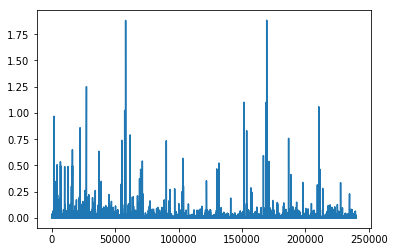

In [138]:
plt.plot(range(len(y_pred_sums)), y_pred_sums)

In [156]:
x_test_y_pred = list(zip(seqs, y_pred_scores, list(range(len(seqs)))))

In [157]:
x_test_y_pred_sorted = sorted(x_test_y_pred, key=lambda x: x[1], reverse=True)

x_test_y_pred_tagged = [(seq, tag, ind) for (seq, score, ind),tag in zip(x_test_y_pred_sorted, y_test)]

In [158]:
x_test_y_pred_tagged = sorted(x_test_y_pred_tagged, key=lambda x: x[2])

In [159]:
sum([tag for (seq, tag, ind) in x_test_y_pred_tagged[:1000]])

9